# 2.2.1 Running the CLPN on Fractals

Assuming the data are there, this NB finetunes the model and tests on the fractals data.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and other non-code related info
%watermark -n -m -g -b -t -h

Mon Aug 31 2020 23:18:12 

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-112-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit
host name  : serrep5
Git hash   : b0fe2e48d5f64678addd1f5ddf3fa82d09e75113
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Conda Env


In [4]:
!conda list

/bin/bash: conda: command not found


## Imports

In [5]:
from pprint import pprint
import os
import numpy as np
from six.moves import cPickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
from keras import backend as K
from keras.preprocessing.image import Iterator
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image, ImageOps

%aimport prevseg.index
import prevseg.index as index
%aimport prevseg.schapiro
import prevseg.schapiro as sch
from prevseg.schapiro import graph, walk

%aimport prednet.kitti_settings
import prednet.kitti_settings as ks
%aimport prednet.prednet_base
import prednet.prednet_base as pn
%aimport prednet.data_utils
import prednet.data_utils as utils

# Keep track of versions of everything
%watermark -v -iv

Using TensorFlow backend.


PIL.Image  7.2.0
numpy      1.19.1
prednet    0+untagged.74.g57d9b43
prevseg    0+untagged.62.gb0fe2e4.dirty
networkx   2.5
matplotlib 3.3.1
CPython 3.7.7
IPython 7.17.0


## Creating the Schapiro Datasets

In [6]:
batch_size = 14
n_pentagons = 3
max_steps = 100
n_paths = 1
source = 1

paths_data = list(index.DIR_SCH_FRACTALS_RS.iterdir())
np.random.shuffle(paths_data)
paths_data = paths_data[:5*n_pentagons]
array_data = np.array([np.load(str(path)) for path in paths_data])

G = sch.graph.schapiro_graph(n_pentagons=n_pentagons)

mapping = {node : path.stem for node, path in zip(range(len(G.nodes)), paths_data)}

In [7]:
def iter_single_sample(G, mode, max_steps, source=None): 
    if mode == 'random':
        iter_walk = sch.walk.walk_random(G, steps=max_steps, source=source)
    elif mode == 'euclidean':
        iter_walk = sch.walk.walk_euclidean(G, source=source)
    elif mode == 'hamiltonian':
        iter_walk = sch.walk.walk_hamiltonian(G, source=source)
    else:
        raise ValueError('Invalid mode entered')

    for sample in iter_walk:
        yield array_data[sample[0]], sample[0]

def iter_batch_sample(G, mode, max_steps, batch_size, source=None):
    iter_batch = zip(*[iter_single_sample(G, mode, max_steps, source=source) 
                       for _ in range(batch_size)])
    for batch in iter_batch:
        data, nodes = zip(*batch)
        yield data, nodes

def iter_batch_dataset(G, mode, max_steps, batch_size, n_paths, source=None):       
    for _ in range(n_paths):
        data, nodes = zip(*list(iter_batch_sample(
            G, mode, max_steps, batch_size, source=source)))
        yield np.moveaxis(np.array(data), 0, 1), nodes

fine_tune_data_iter = iter_batch_dataset(G, 'random', max_steps, batch_size, n_paths)
fine_tune_data, fine_tune_nodes = next(fine_tune_data_iter)
fine_tune_data.shape

(14, 100, 3, 128, 160)

### Testing Dataset

In [8]:
euclidean_iter = iter_batch_dataset(G, 'euclidean', None, 1, n_paths, source=source)
_, euclidean_nodes = next(euclidean_iter)

In [9]:
euclidean_nodes = list(np.array(euclidean_nodes).reshape(30))
euclidean_nodes

[1,
 4,
 3,
 2,
 4,
 5,
 8,
 9,
 7,
 8,
 6,
 7,
 5,
 6,
 9,
 10,
 13,
 14,
 12,
 13,
 11,
 12,
 10,
 11,
 14,
 0,
 3,
 1,
 2,
 0]

In [10]:
# Inlcude some non-important steps the start to allow the hidden state to adapt
initial_padding = [1,0,1,0,1,0]
test_walk_nodes = initial_padding + euclidean_nodes

test_data = np.expand_dims(np.array([array_data[n] for n in test_walk_nodes]),0)
test_data.shape

(1, 36, 3, 128, 160)

### Using Sequence Generators

In [11]:
class ShapiroFractalsDataset(Iterator):
    modes = set(('random', 'euclidean', 'hamiltonian'))
    def __init__(self, batch_size=32, n_pentagons=3, max_steps=128, n_paths=128,
                 mapping=None, mode='random', debug=False, seed=None, shuffle=False):
        self.batch_size = batch_size
        self.n_pentagons = n_pentagons
        self.max_steps = max_steps
        self.n_paths = n_paths
        self.mapping = mapping
        self.mode = mode
        self.debug = debug
        assert self.mode in self.modes
        
        self.G = graph.schapiro_graph(n_pentagons=n_pentagons)
        
        self.load_node_stimuli()
        
        self.mapping = {node : path.stem
                        for node, path in zip(range(len(self.G.nodes)),
                                              self.paths_data)}
        print(f'Created mapping as follows:\n{self.mapping}')
        
        if self.debug:
            self.sample_transform = lambda sample : sample
        else:
            self.sample_transform = lambda sample : self.array_data[sample]
        super().__init__(self.n_paths, self.batch_size, shuffle, seed)
        
    def load_node_stimuli(self):
        # Load the fractal images into memory
        assert index.DIR_SCH_FRACTALS_RS.exists()
        if self.mapping:
            self.paths_data = [index.DIR_SCH_FRACTALS_RS / (name+'.npy')
                               for name in self.mapping.values()]
        else:
            paths_data = list(index.DIR_SCH_FRACTALS_RS.iterdir())
            np.random.shuffle(paths_data)
            self.paths_data = paths_data[:5*self.n_pentagons]
        self.array_data = np.array([np.load(str(path)) for path in self.paths_data])
        
    def iter_single_sample(self): 
        if self.mode == 'random':
            iter_walk = sch.walk.walk_random(self.G, steps=self.max_steps)
        elif self.mode == 'euclidean':
            iter_walk = sch.walk.walk_euclidean(self.G)
        elif self.mode == 'hamiltonian':
            iter_walk = sch.walk.walk_hamiltonian(self.G)

        for sample in iter_walk:
            yield self.array_data[sample[0]], sample[0]
        
    def iter_batch_sample(self):
        iter_batch = zip(*[self.iter_single_sample()
                           for _ in range(self.batch_size)])
        for batch in iter_batch:
            data, nodes = zip(*batch)
            yield data, nodes
        
    def iter_batch_dataset(self):   
        for _ in range(self.n_paths):
            data, nodes = zip(*list(self.iter_batch_sample()))
            yield np.moveaxis(np.array(data), 0, 1), nodes
        
    def __iter__(self):
        return self.iter_batch_dataset()
    
    def __getitem__(self, null):
        data_iter = self.iter_batch_dataset()
        data = next(data_iter)[0]
        data2 = np.zeros(data.shape)
        data2[:,:-1,:,:,:] = data[:,1:,:,:,:]
        return data, data2
    
max_steps = 100
epochs = 1
batch_size = 14
n_paths = 1

iter_ds = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths,
                                 mapping=mapping)
for _ in range(epochs):
    for i, batch in enumerate(iter_ds):
        print(i, batch[0].shape)
        if i > max_steps+5:
            print('bad')
            break

Created mapping as follows:
{0: '98', 1: '11', 2: '99', 3: '75', 4: '87', 5: '38', 6: '73', 7: '41', 8: '83', 9: '54', 10: '56', 11: '40', 12: '42', 13: '6', 14: '36'}
0 (14, 100, 3, 128, 160)


### Reference Schapiro Graph

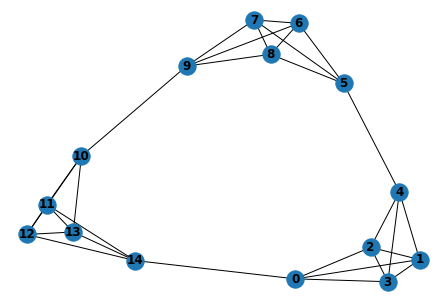

In [12]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

## Fine Tuning on the Fractals

In [13]:
nt = fine_tune_data.shape[1]
extrap_start_time = 10  # starting at this time step, the prediction from the previous time step will be treated as the actual input
orig_weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights.hdf5')  # original t+1 weights
orig_json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model.json')

fractals_weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights-fractals_finetuned.hdf5')  # where new weights will be saved
fractals_json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model-fractals_finetuned.json')

Ran out of GPU memory so I'm doing something wrong. Need to investigate the sequence generator.

```
ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[14,48,128,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node prednet_1_1/while/convolution_17}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Mean/_1123]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[14,48,128,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node prednet_1_1/while/convolution_17}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.
```

Might be trying to load the whole sequence into memory. Try just 15 frames.

## Training with batch_size=3

Turns out it wasn't path length but the batch size.

Turns out, turns out, setting the pathlength to something small first, and then making it large, allows the model to train. But starting from a large path length (>20) causes out of memory issues.

Combinations tried and results on the first try:

- batch_size, max_steps, success
- 4, 100, False
- 4, 50, False
- 4, 20, True
- 3, 100, False
- 3, 75, True
- 2, 100, True

In [14]:
nt = fine_tune_data.shape[1]
orig_weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights.hdf5')  # original t+1 weights
orig_json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model.json')

fractals_weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights-fractals_finetuned.hdf5')  # where new weights will be saved
fractals_json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model-fractals_finetuned.json')

In [ ]:
save_model = True
nb_epoch = 200
batch_size = 3
samples_per_epoch = None
N_seq_val = 50  # number of sequences to use for validation
max_steps = 75
n_paths = 150
nt = max_steps

# Load t+1 model
f = open(orig_json_file, 'r')
json_string = f.read()
f.close()
orig_model = model_from_json(json_string, custom_objects = {'PredNet': pn.PredNet})
orig_model.load_weights(orig_weights_file)

layer_config = orig_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
prednet = pn.PredNet(weights=orig_model.layers[1].get_weights(), **layer_config)

input_shape = list(orig_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt

inputs = Input(input_shape)
predictions = prednet(inputs)
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_absolute_error', optimizer='adam')

train_generator = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths,
                                    mapping=mapping)
val_generator = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths,
                                  mapping=mapping)
                                  
lr_schedule = lambda epoch: 0.000333 if epoch < 100 else 0.0001    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
callbacks = [LearningRateScheduler(lr_schedule)]
if save_model:
    if not ks.WEIGHTS_DIR.exists(): 
        ks.WEIGHTS_DIR.mkdir(parents=True)
    callbacks.append(ModelCheckpoint(filepath=fractals_weights_file, monitor='loss', save_best_only=True))
history = model.fit_generator(train_generator, samples_per_epoch, nb_epoch, callbacks=callbacks,
                validation_data=None)

if save_model:
    json_string = model.to_json()
    with open(fractals_json_file, "w") as f:
        f.write(json_string)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Created mapping as follows:
{0: '98', 1: '11', 2: '99', 3: '75', 4: '87', 5: '38', 6: '73', 7: '41', 8: '83', 9: '54', 10: '56', 11: '40', 12: '42', 13: '6', 14: '36'}
Created mapping as follows:
{0: '98', 1: '11', 2: '99', 3: '75', 4: '87', 5: '38', 6: '73', 7: '41', 8: '83', 9: '54', 10: '56', 11: '40', 12: '42', 13: '6', 14: '36'}
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/200
32/50 [==================>...........] - ETA: 54s - loss: 80.2706